<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_SLSTR_advanced/2_1_SLSTR_advanced_data_access_eumdac.ipynb" target="_blank"><< Advanced SLSTR data access with the EUMDAC client</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-slstr/main?labpath=2_SLSTR_advanced%2F2_2_SLSTR_channel_comparison_cloud_flagging.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn SLSTR: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
Users should review the following notebooks for more information on setting up a credentials files for using the eumdac python library to retrieve SLSTR data from the Data Store:
    
- **<a href="../1_SLSTR_introductory/1_1a_SLSTR_data_access_Data_Store.ipynb">1_1a_SLSTR_data_access_Data_Store.ipynb</a>**

You will also need to have registered for a **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** to download from the EUMETSAT Data Store.

</div>
<hr>

# 2.2 SLSTR channel comparison and cloud flagging

### Data used

| Product Description | Data Store collection ID| Product Navigator |
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-3 SLSTR level-1B  | EO:EUM:DAT:0411 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_1_RBT___NTC?query=slstr&&results=24&s=advanced" target="_blank">link</a> |
| CMEMS global ocean OSTIA diurnal skin SST | SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 | <a href="https://resources.marine.copernicus.eu/product-detail/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014/INFORMATION" target="_blank">link</a> |
| CMEMS global ocean OSTIA foundation SST | SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001 | <a href="https://resources.marine.copernicus.eu/product-detail/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001/INFORMATION" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* LO 1
* LO 2

### Outline

Blurb....

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
1. [Step 0: A quick preamble in functions](#section0)
1. [Step 1: Acquiring SLSTR level-1B data](#section1)
1. [Step 2: Reading in the radiance and brightness temperature data](#section2)
1. [Step 3: Comparing visible and thermal channel data](#section3)
1. [Step 4: Developing cloud masks](#section4)
1. [Step 5: Comparing the level-4 data](#section5)

<hr>

When we use Python, we nearly always start by importing the libraries we need. Each library gives us access to the capabilities we need to perform specific tasks. We can import library as shown in the box below.

In [1]:
import cartopy                          # a library that support mapping
import datetime                         # a libary that allows us to work with dates and times
import xarray as xr                     # a library that supports the use of multi-dimensional arrays in Python
import glob                             # a library that aids in searching for files
import json                             # a library that helps us make JSON format files
import numpy as np                      # a library that lets us work with arrays; we import this with a new name "np"
import os                               # a library that allows us access to basic operating system commands
import shutil                           # a library that allows us access to basic operating system commands like copy
import zipfile                          # a library that allows us to unzip zip-files.
import matplotlib.pyplot as plt         # a library that support plotting
import matplotlib.ticker as mticker     # a library that extends plotting support
from shapely.geometry import Polygon    # a library that helps us work with shape objects
from scipy.interpolate import griddata  # a library that supports irregular grid interpolation
import xml.etree.ElementTree as ET      # a library that helps us parse XML files
import eumdac                           # a tool that helps us download via the eumetsat/data-store
import eumartools                       # a EUMETSAT library that support working with Sentinel-3 products

Next we will create a download directory to store the products we will download in this notebook.

In [2]:
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. A quick preamble on functions
[Back to top](#TOC_TOP)

</div>

In [3]:
def embellish_plot(m):
    """Quick function to embellish SLSTR plots with gridlines and labels

    Args:
        m (axis): the axis to plot into
    Returns:
        None
    """
    # Embellish with gridlines
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    m.axis('off')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Step 1: Acquiring SLSTR level-1B data
[Back to top](#TOC_TOP)

</div>

Before we use the Data Store to download data, we must first authenticate our access and retrieve an access token. More **essential** information on setting this up can be found in the **<a href="../1_SLSTR_introductory/1_1a_SLSTR_data_access_Data_Store.ipynb">1_1a_SLSTR_data_access_Data_Store</a>** notebook.

In [4]:
# load credentials
with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
    credentials = json.load(json_file)
    token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
    print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token 'b78cc44c-55c6-3c6b-9387-b97202cec219' expires 2022-09-05 09:27:16.546545


We will work with the SLSTR level-1B reduced resolution data throughout this notebook. The **collection ID** for this data type is `EO:EUM:DAT:0411`. You can find this information on the Data Store (https://data.eumetsat.int/), or ask the `eumdac` client to tell you all the avaiable collections by calling the `eumdac.DataStore(token).collections` method. We can use our collection ID to create a collection object (`selected_collection`) and ask for more information on the collection as follows.

In [5]:
# set collection ID for SLSTR level-1B
collectionID = 'EO:EUM:DAT:0411'

# Use collection ID
selected_collection = datastore.get_collection(collectionID)
print(f"{selected_collection.title}\n---\n{selected_collection.abstract}")

SLSTR Level 1B Radiances and Brightness Temperatures - Sentinel-3
---
The SLSTR level 1 products contain: the radiances of the 6 visible (VIS), Near Infra-Red (NIR) and Short Wave Infra-Red (SWIR) bands (on the A and B stripe grids); the Brightness Temperature (BT) for the 3 Thermal Infra-Red (TIR) bands; the BT for the 2 Fire (FIR) bands. Resolution: 1km at nadir (TIR), 500m (VIS). All are provided for both the oblique and nadir view. These measurements are accompanied with grid and time information, quality flags, error estimates and meteorological auxiliary data. - All Sentinel-3 NRT products are available at pick-up point in less than 3h - All Sentinel-3 Non Time Critical (NTC) products are available at pick-up point in less than 30 days. Sentinel-3 is part of a series of Sentinel satellites, under the umbrella of the EU Copernicus programme.


Now we have defined our collection, we can request products from it. In this case we are interested in the specific product defined below.

In [6]:
productID = 'S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3'
selected_product = datastore.get_product(product_id=productID, collection_id=collectionID)

Now we will download the product (which will be zipped), unzip it, and clear up the latent zip file.

In [7]:
# Download the product
with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
    print(f'Downloading {fsrc.name}')
    shutil.copyfileobj(fsrc, fdst)
    print(f'Download of product {fsrc.name} finished.')

# Unzip the product
with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith(str(selected_product)):
            zip_ref.extract(file, download_dir)
    print(f'Unzipping of product {selected_product} finished.')

# Clean up
os.remove(fdst.name)

Download of product S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3.zip finished.
Unzipping of product S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3 finished.


We will also download **only** the manifest files for a few other products. This will allow us to plot the extents of the swath without gathering all of the data.

In [8]:
productIDs = ['S3B_SL_1_RBT____20220318T214831_20220318T215131_20220320T063651_0179_063_385_5400_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T214531_20220318T214831_20220320T063542_0179_063_385_5220_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T204657_20220318T204957_20220320T044554_0179_083_142_5400_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T204357_20220318T204657_20220320T044445_0179_083_142_5220_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T200732_20220318T201032_20220320T043253_0179_063_384_5400_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T083003_20220318T083303_20220319T165622_0180_083_135_3600_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T082703_20220318T083003_20220319T165513_0179_083_135_3420_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T074737_20220318T075037_20220319T164449_0179_063_377_3420_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T064903_20220318T065203_20220319T142954_0179_083_134_3600_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3']
              
for productID, count in zip(productIDs, range(len(productIDs))):
    selected_product = datastore.get_product(product_id=productID, collection_id=collectionID)
    for entry in selected_product.entries:
        if 'xfdumanifest.xml' in entry:
            with selected_product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products', 
                                                        fsrc.name.replace('.xml', f"{str(count).zfill(2)}.xml")),
                                                        mode='wb') as fdst:
                print(f'Downloading {fsrc.name}.')
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of file {fsrc.name} finished.')

Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.


If all went well, your products are now downloaded. You can find them in the `products` directory in the same folder as this notebook.

<div class="alert alert-info" role="alert">

## <a id='section2'></a>Step 2: Reading in the radiance and brightness temperature data
[Back to top](#TOC_TOP)

</div>

Description of channels we need...

In [9]:
# read all the bands from our products: nadir and a-stripe
solar_channels = [1,2,3,5]
TIR_channels = [7,9]

Signposting to the data location...

In [10]:
# selecting SAFE directory:
SAFE_directory = os.path.join(os.getcwd(), 'products', 
    'S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3')

Reading geolocation grids (to help with plotting, *in*/*io* comparison and interp)

In [11]:
# read geodetic grids
coords_dict = {}
for coords in ["io", "in", "an"]:
    coords_file = xr.open_mfdataset(os.path.join(SAFE_directory, f'geodetic_{coords}.nc'))
    coords_dict[f"longitude_{coords}"] = np.array(coords_file[f"longitude_{coords}"].data)
    coords_dict[f"latitude_{coords}"] = np.array(coords_file[f"latitude_{coords}"].data)
    coords_file.close()

# calculate "io" extents for later use
extents = [np.nanmin(coords_dict["longitude_io"]),
           np.nanmax(coords_dict["longitude_io"]),
           np.nanmin(coords_dict["latitude_io"]),
           np.nanmax(coords_dict["latitude_io"])]

Reading in the data...

In [12]:
# open data
band_dict = {}

# read file
for pattern, bands_needed, flag_file, flag_var in zip(['S*radiance_an.nc', 'S*BT_in.nc', 'S*BT_io.nc'], 
                                                 [solar_channels, TIR_channels, TIR_channels],
                                                 ["flags_an.nc", "flags_in.nc", "flags_io.nc"],
                                                 ["confidence_an", "confidence_in", "confidence_io"]):
    band_files = glob.glob(os.path.join(SAFE_directory, pattern))
    band_vars = xr.open_mfdataset(band_files)

    # read variables
    for band_var in band_vars:
        band_num = int(band_var.split('_')[0][1])
        if band_num in bands_needed and "exception" not in band_var and "orphan" not in band_var:
            print(f"Reading:  {band_var}")
            band_dict[band_var] = band_vars[band_var].data
    band_vars.close()

    # add flags
    flag_path = glob.glob(os.path.join(SAFE_directory, flag_file))[0]        
    print(f"Reading:  {flag_var} (flags)")
    band_dict[flag_file.replace(".nc","_cloud")] = eumartools.flag_mask(flag_path, flag_var, ["summary_cloud"], dtype=np.uint64)
    band_dict[flag_file.replace(".nc","_ocean")] = eumartools.flag_mask(flag_path, flag_var, ["ocean"], dtype=np.uint64)
    band_dict[flag_file.replace(".nc","_land")]  = eumartools.flag_mask(flag_path, flag_var, ["land"], dtype=np.uint64)

Reading:  S1_radiance_an
Reading:  S2_radiance_an
Reading:  S3_radiance_an
Reading:  S5_radiance_an
Reading:  confidence_an (flags)
Reading:  S7_BT_in
Reading:  S9_BT_in
Reading:  confidence_in (flags)
Reading:  S7_BT_io
Reading:  S9_BT_io
Reading:  confidence_io (flags)


<div class="alert alert-info" role="alert">

## <a id='section3'></a>Step 3: Comparing visible and thermal channel data
[Back to top](#TOC_TOP)

</div>

Plot 1, S1:2:3 RGB vs S9

In [13]:
# False colour solar channels
red_recipe = np.array(band_dict['S3_radiance_an'])
green_recipe = np.array(band_dict['S2_radiance_an'])
blue_recipe = np.array(band_dict['S1_radiance_an'])

rgb_fsc_321 = np.dstack((red_recipe, green_recipe, blue_recipe))
rgb_fsc_321 = eumartools.normalise_image(rgb_fsc_321, unhitch=False)
rgb_fsc_321 = eumartools.truncate_image(rgb_fsc_321, min_percentile=5.0, max_percentile=95.0)
band_dict["rgb_fsc_321"] = eumartools.histogram_image(rgb_fsc_321, nbins=2048)

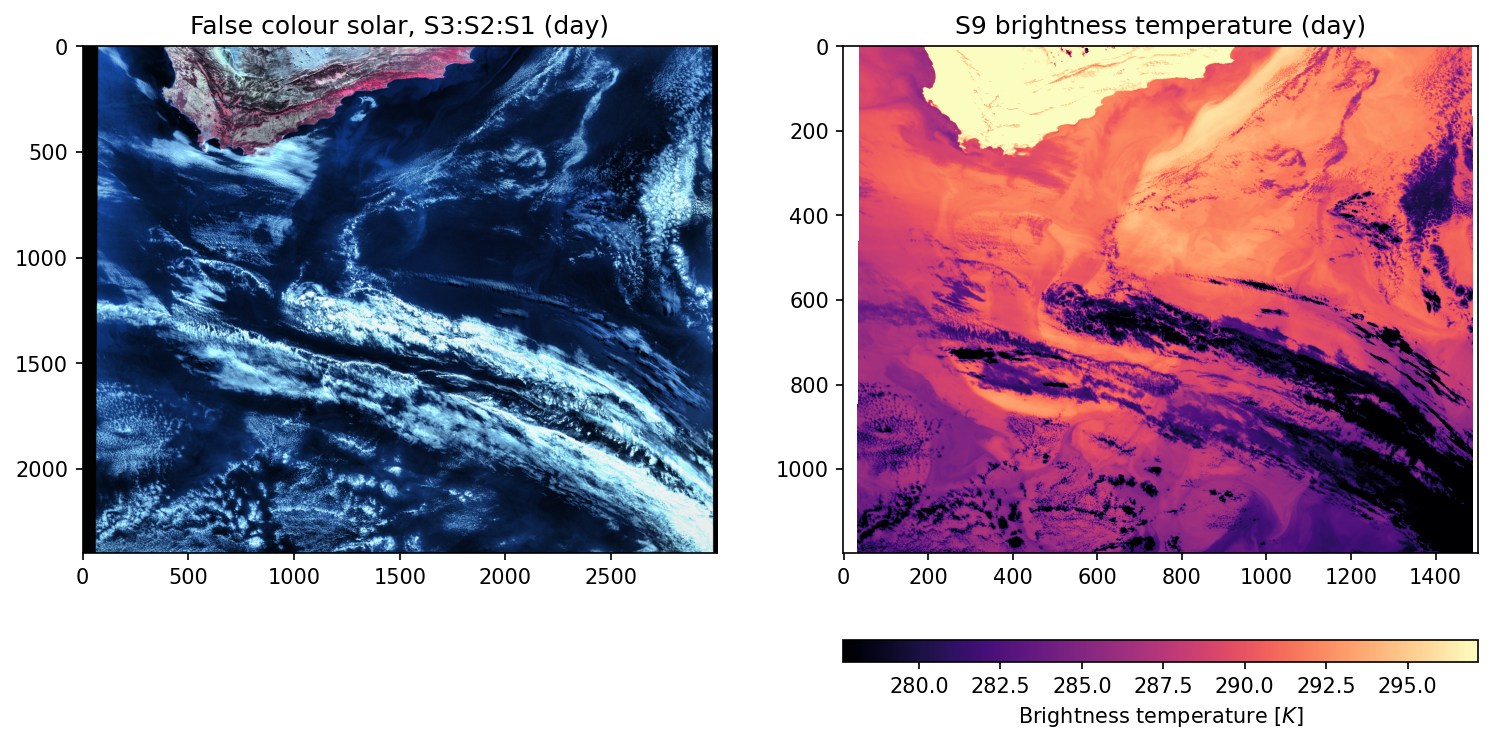

In [14]:
# plot S1:S2:S3 RGB and S9 TIR side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)
axs[0].imshow(band_dict["rgb_fsc_321"])
axs[0].title.set_text('False colour solar, S3:S2:S1 (day)')

vmin, vmax = [np.nanpercentile(np.array(band_dict['S9_BT_in']), 5),
              np.nanpercentile(np.array(band_dict['S9_BT_in']), 95)]

c = axs[1].imshow(band_dict['S9_BT_in'], cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].title.set_text('S9 brightness temperature (day)')
cb_ax = fig.add_axes([axs[1].get_position().x0, 0.10, axs[1].get_position().width, 0.025])
fig.colorbar(c, cax=cb_ax, orientation="horizontal", label='Brightness temperature [$K$]');

Compare what you can see. Much more structure in TIR.

Plot 2, S7 io vs in grids. I chose to plot all as maps with pcolormesh. This is slower, but enable io and in grids to be compared spatially without interp, which takes a while on irregular grids.

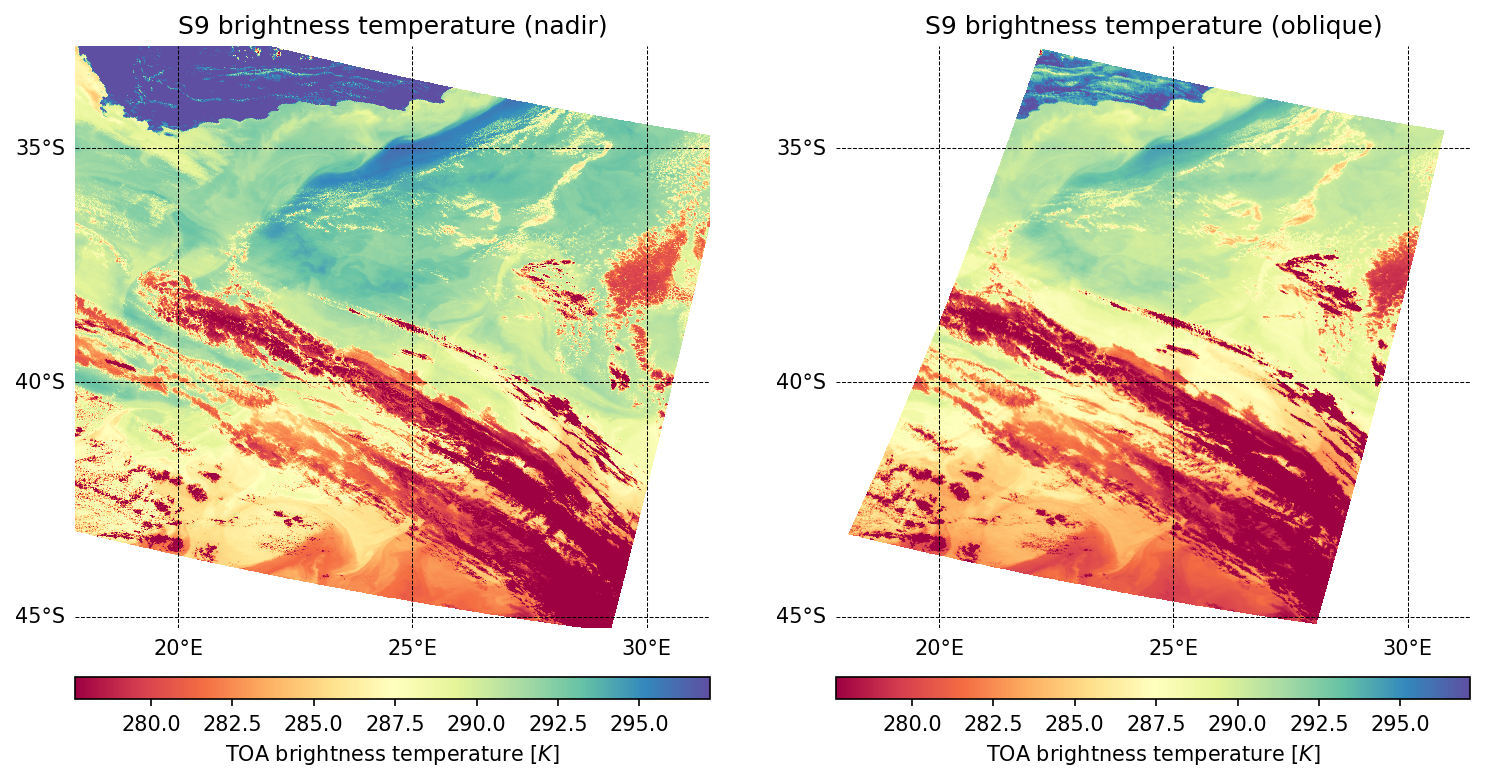

In [15]:
# plot S9 nadir and S9 oblique by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})
titles = ['S9 brightness temperature (nadir)', 'S9 brightness temperature (oblique)']
labels = ['TOA brightness temperature [$K$]', 'TOA brightness temperature [$K$]']
views = ['in', 'io']

vmin, vmax = [np.nanpercentile(np.array(band_dict['S9_BT_in']), 5),
              np.nanpercentile(np.array(band_dict['S9_BT_in']), 95)]

for m, label, title, view in zip(axs, labels, titles, views):
    c = m.pcolormesh(coords_dict[f"longitude_{view}"],
                      coords_dict[f"latitude_{view}"],
                      band_dict[f"S9_BT_{view}"],
                      transform=cartopy.crs.PlateCarree(central_longitude=0.0),
                      cmap=plt.cm.Spectral, vmin=vmin, vmax=vmax)
    m.set_extent(extents, crs=cartopy.crs.PlateCarree())
    m.title.set_text(title)
    embellish_plot(m)    
    cb_ax = fig.add_axes([m.get_position().x0, 0.100, m.get_position().width, 0.025])
    fig.colorbar(c, cax=cb_ax, orientation="horizontal", label=label)

Compare S9 with S7 - why can't we use S7 during the day?

In [16]:
# plot S7 oblique and S9 oblique by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})
titles = ['S7 brightness temperature (oblique)', 'S9 brightness temperature (oblique)']
labels = ['TOA brightness temperature [$K$]', 'TOA brightness temperature [$K$]']
bands = ['S7_BT_io', 'S9_BT_io']

for m, label, title, band in zip(axs, labels, titles, bands):
    
    vmin, vmax = [np.nanpercentile(np.array(band_dict[band]), 5),
              np.nanpercentile(np.array(band_dict[band]), 95)]

    c = m.pcolormesh(coords_dict[f"longitude_io"],
                      coords_dict[f"latitude_io"],
                      band_dict[band],
                      transform=cartopy.crs.PlateCarree(central_longitude=0.0),
                      cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
    m.set_extent(extents, crs=cartopy.crs.PlateCarree())
    m.title.set_text(title)
    embellish_plot(m)    
    cb_ax = fig.add_axes([m.get_position().x0, 0.100, m.get_position().width, 0.025])
    fig.colorbar(c, cax=cb_ax, orientation="horizontal", label=label)

Compare. Different magnitudes, esp at eastern edge of scene. Different atmos path length.

<div class="alert alert-info" role="alert">

## <a id='section4'></a>Step 4: Developing cloud masks
[Back to top](#TOC_TOP)

</div>

Lets look at the SLSTR summary cloud mask...(describe this)

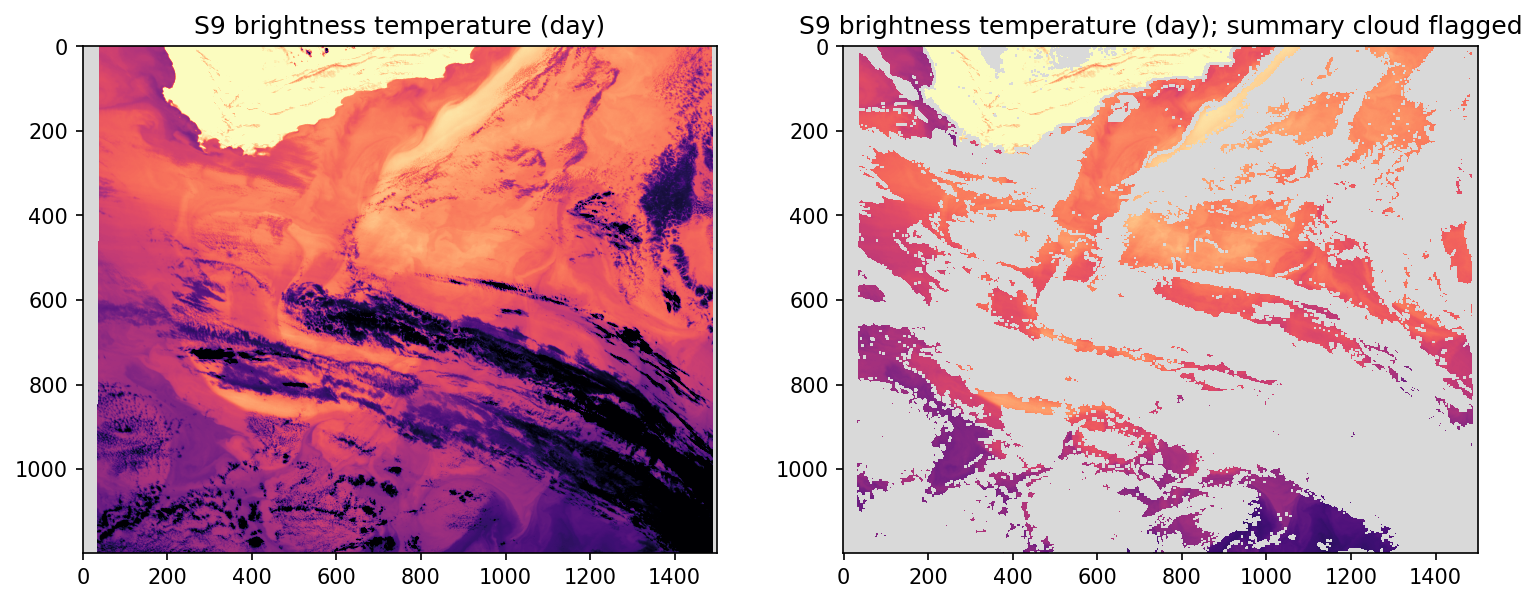

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10), dpi=150)
cloud_var = np.array(band_dict[f"S9_BT_in"])
vmin, vmax = [np.nanpercentile(cloud_var, 5), np.nanpercentile(cloud_var, 95)]
cloud_var[np.array(band_dict['flags_in_cloud']) == 1] = np.nan

c = axs[0].imshow(band_dict[f"S9_BT_in"], cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[0].set_facecolor("0.85")
axs[0].title.set_text('S9 brightness temperature (day)')
c = axs[1].imshow(cloud_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].set_facecolor("0.85")
axs[1].title.set_text('S9 brightness temperature (day); summary cloud flagged')

Can we recreate this based on what we learned in the lectures? Method 1: clouds are bright. Using S5 to mask S9.

In [18]:
# S5 threshold [mW.m^-2.sr^-1.nm^-1]
threshold_value = 2

test_var = np.array(band_dict[f"S9_BT_in"])
cloud_mask = np.zeros(np.shape(band_dict[f"S5_radiance_an"]))
cloud_mask[np.array(band_dict[f"S5_radiance_an"]) > threshold_value] = np.nan
cloud_mask = cloud_mask[::2, ::2]

test_var[np.isnan(cloud_mask)] = np.nan

fig, axs = plt.subplots(1, 2, figsize=(12, 10), dpi=150)
c = axs[0].imshow(test_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[0].set_facecolor("0.85")
axs[0].title.set_text('S9 brightness temperature (day); test masked')
c = axs[1].imshow(cloud_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].set_facecolor("0.85")
axs[1].title.set_text('S9 brightness temperature (day); summary cloud flagged')

Method 2. Clouds are cold. Thresholding TIR channels.

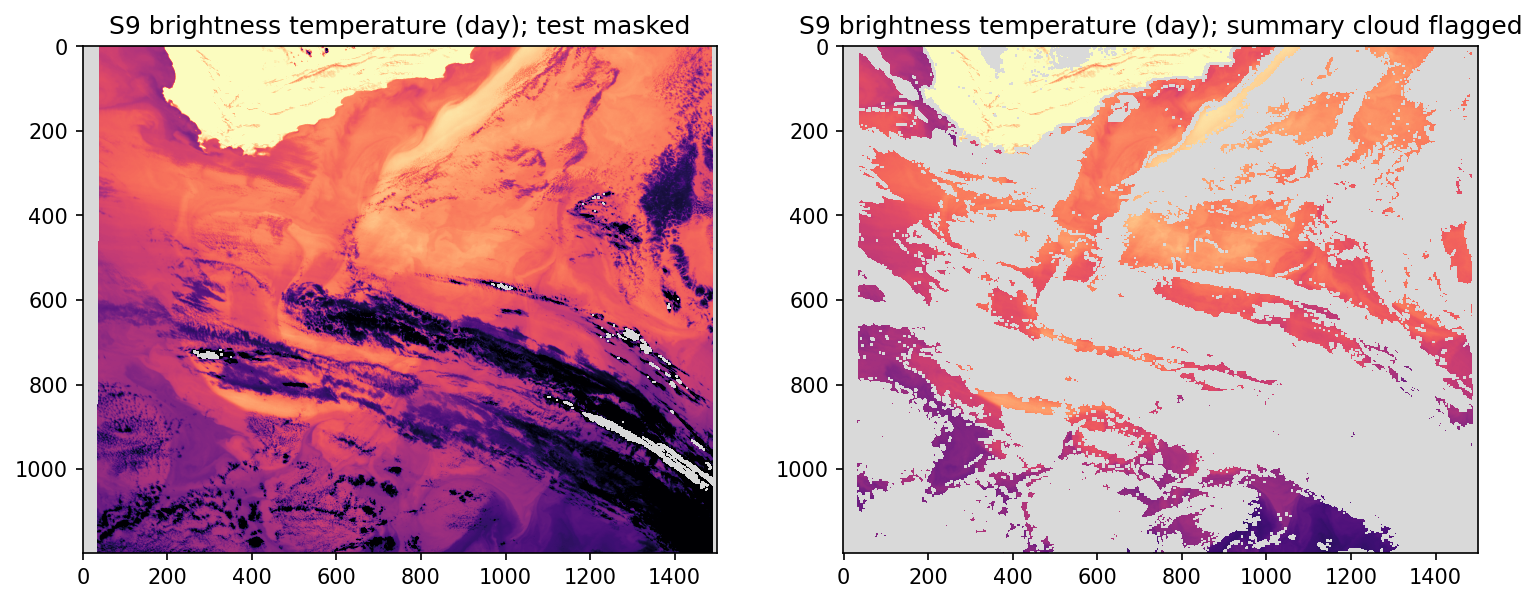

In [19]:
# S9 threshold [K]
threshold_value = 271.35 - 10

test_var = np.array(band_dict[f"S9_BT_in"])
test_var[test_var < threshold_value] = np.nan

fig, axs = plt.subplots(1, 2, figsize=(12, 10), dpi=150)
c = axs[0].imshow(test_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[0].set_facecolor("0.85")
axs[0].title.set_text('S9 brightness temperature (day); test masked')
c = axs[1].imshow(cloud_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].set_facecolor("0.85")
axs[1].title.set_text('S9 brightness temperature (day); summary cloud flagged')

<div class="alert alert-info" role="alert">

## <a id='section5'></a>Step 5: Comparing the level-4 data
[Back to top](#TOC_TOP)

</div>

Read all the manifest files

In [20]:
# selecting SAFE manifest
SAFE_manifests = glob.glob(os.path.join(download_dir, 'xfd*.xml'))

Plot all the manifest files

In [21]:
fig, m = plt.subplots(1, 1, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})
m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
gl = m.gridlines(draw_labels = True)

for SAFE_manifest in SAFE_manifests:
    tree = ET.parse(SAFE_manifest)
    root = tree.getroot()
    polygon = root.findall('.//gml:posList', {'gml':"http://www.opengis.net/gml"})[0].text
    pass_dir = root.findall('.//sentinel-safe:passNumber',
                            {'sentinel-safe':"http://www.esa.int/safe/sentinel/1.1"})[0].attrib['groundTrackDirection']
    coords = np.asarray(polygon.split(' ')).astype('float')
    if pass_dir == "descending":    
        polygon_geom = Polygon(zip((coords[1::2]), coords[0::2]))
        colour='r'
    else:
        polygon_geom = Polygon(zip((coords[1::2][::-1]), coords[0::2][::-1]))
        colour='b'
    x, y = polygon_geom.exterior.xy
    p, = plt.fill(x, y, alpha=0.74, fc=colour, ec='k', transform=cartopy.crs.Geodetic())
plt.title('Level-1B SLSTR granule coverage for ascending (blue) and descending (red) passes for 18.03.22');

Read OSTIA foundation data for 18.03.2022 (same day). Also have skin for 07:30 (assume UTC and so same as SLSTR image overpass time) for same day.

In [22]:
# selecting OSTIA products
OSTIA_foundation_file = os.path.join(os.getcwd(), 'OSTIA', 'OSTIA_foundation_temperature_18032022.nc')
OSTIA_skin_file = os.path.join(os.getcwd(), 'OSTIA', 'OSTIA_skin_temperature_18032022_0730.nc')

In [23]:
# opening the products
OSTIA_fSST = xr.open_dataset(OSTIA_foundation_file)
OSTIA_sSST = xr.open_dataset(OSTIA_skin_file)

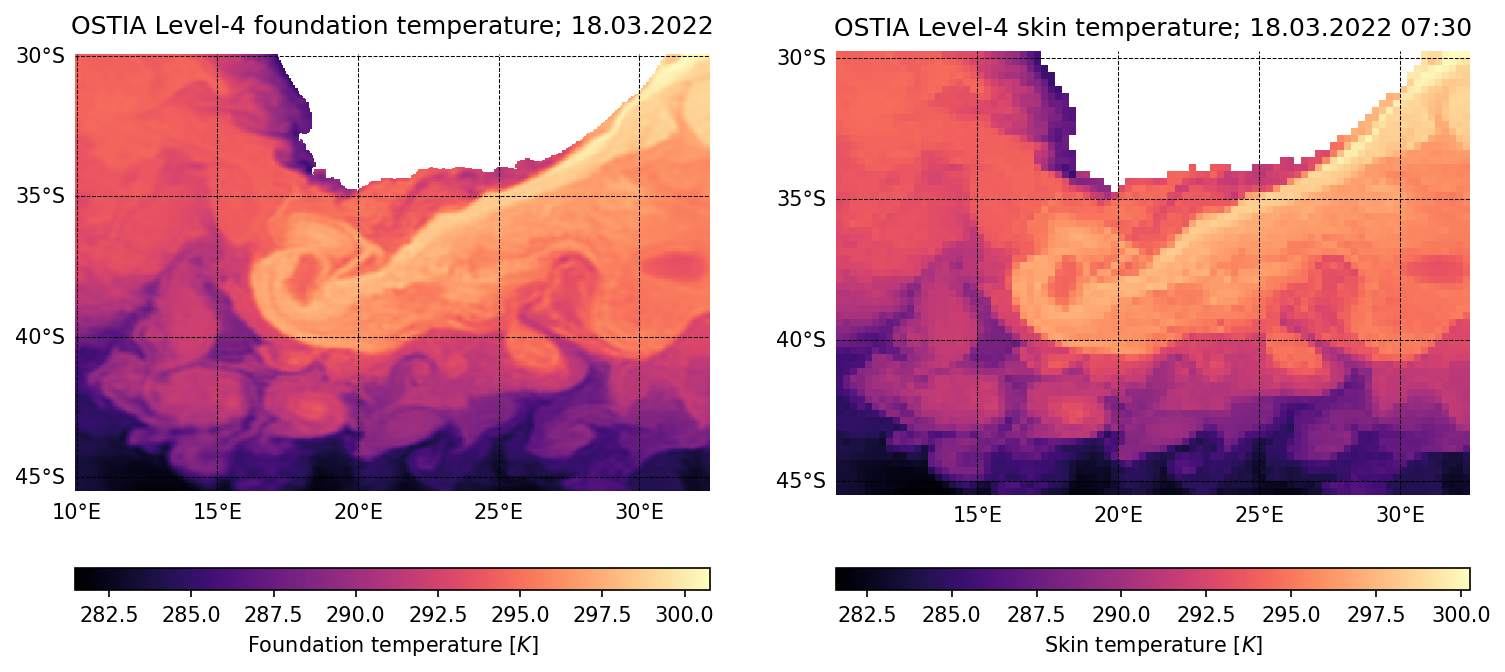

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})

labels = ['Foundation temperature [$K$]', 'Skin temperature [$K$]']
titles = ['OSTIA Level-4 foundation temperature; 18.03.2022', 'OSTIA Level-4 skin temperature; 18.03.2022 07:30']
products = [OSTIA_fSST, OSTIA_sSST]

for m, product, label, title in zip(axs, products, labels, titles):
    c = m.pcolormesh(product["lon"], product["lat"], np.squeeze(product["analysed_sst"]), cmap=plt.cm.magma)
    m.title.set_text(title)
    embellish_plot(m)    
    cb_ax = fig.add_axes([m.get_position().x0, 0.15, m.get_position().width, 0.025])
    fig.colorbar(c, cax=cb_ax, orientation="horizontal", label=label);

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_SLSTR_advanced/2_1_SLSTR_advanced_data_access_eumdac.ipynb" target="_blank"><< Advanced SLSTR data access with the EUMDAC client</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>